In [2]:
from scipy.special import j1
import jax.numpy as np
import matplotlib.pyplot as plt
import jax.random as jr
import dLux as dl
import dLuxToliman as dlT

In [30]:
B=200
min_wavelength = 560e-9
max_wavelength = (610e-9)*B
delta_wavelength = max_wavelength - min_wavelength
n_wavelengths = 1024

period = 220e-6
diameter = 0.125

wavelengths = np.linspace(min_wavelength, max_wavelength, n_wavelengths)

# percentage over in xvals: 10% of wavlength range
x_buffer = 0.1

min_x = (np.sqrt(2)/period) * (min_wavelength - x_buffer * delta_wavelength)
max_x = (np.sqrt(2)/period) * (max_wavelength + x_buffer * delta_wavelength)

# adding lots of x values to sample
n_x = int(np.ceil((1+2*x_buffer)*n_wavelengths))

x = np.linspace(min_x, max_x, n_x)

K = np.zeros((n_x, n_wavelengths))

for i, wl in enumerate(wavelengths):
    arg = np.pi*diameter*(x/wl - np.sqrt(2)/period)
    factor = ((np.pi * diameter**2)/wl**2)

    # to avoid divide by zero errors, us np,where
    norm_psf = np.where(arg == 0, factor/4, factor * (j1(arg))**2 / (arg)**2)
    K = K.at[:,i].set(norm_psf)

In [31]:
U, S, Vt = np.linalg.svd(K, full_matrices=False)
V = Vt.T

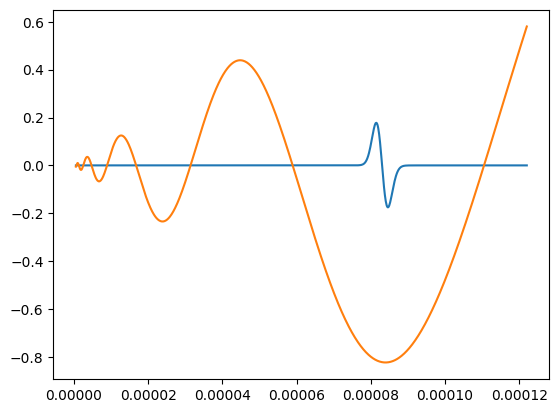

In [70]:
om=5
plt.plot(wavelengths, V[:,1])
plt.plot(wavelengths, 10000*(wavelengths**(1j*om+1)))
plt.show()

In [118]:
# code for generating an arbitrary flux spectrum:
key = jr.PRNGKey(70)

# Create a complex array of zeros
spectrum = np.zeros(n_wavelengths, dtype=np.complex64)

d_wl = wavelengths[1]-wavelengths[0]
fs = 1 / d_wl           # sampling frequency
freqs = np.fft.fftfreq(n_wavelengths, d=d_wl)

# Desired frequency band (in Hz)
f_low = 0

max_spec_freq = (np.sqrt(2)/period) * (diameter/min_wavelength)

f_high = 2 * max_spec_freq
# Get indices of freqs within band (positive freqs only)
band_mask = (freqs >= f_low) & (freqs <= f_high)

# Random amplitudes and phases
amp_key, phase_key = jr.split(key)
random_amplitudes = jr.normal(amp_key, shape=(n_wavelengths,)) * band_mask
random_phases = jr.uniform(phase_key, shape=(n_wavelengths,), minval=0.0, maxval=2 * np.pi)

# Assign complex values
spectrum = random_amplitudes * np.exp(1j * random_phases)

# Make symmetric to ensure real time-domain signal
# Copy positive freqs into negative side
def make_hermitian(spec):
    spec = spec.at[1:n_wavelengths//2].set(spec[1:n_wavelengths//2])
    spec = spec.at[-(n_wavelengths//2)+1:].set(np.conj(spec[1:n_wavelengths//2][::-1]))
    return spec

spectrum = make_hermitian(spectrum)

signal = np.fft.ifft(spectrum).real
spectrum_filtered_bad = spectrum.at[np.abs(freqs) > max_spec_freq].set(0)
signal_filtered_bad = np.fft.ifft(spectrum_filtered_bad).real

if np.min(signal) <= 0:
    signal_filtered_bad += -2*np.min(signal)
    signal += -2*np.min(signal)

In [119]:
# 6) Project the spectrum onto the singular vectors
c = V.T @ signal

# 7) Reconstruct only modes with singular value above threshold
threshold = S[164]
mask = S >= threshold
signal_rec = V[:, mask] @ c[mask]

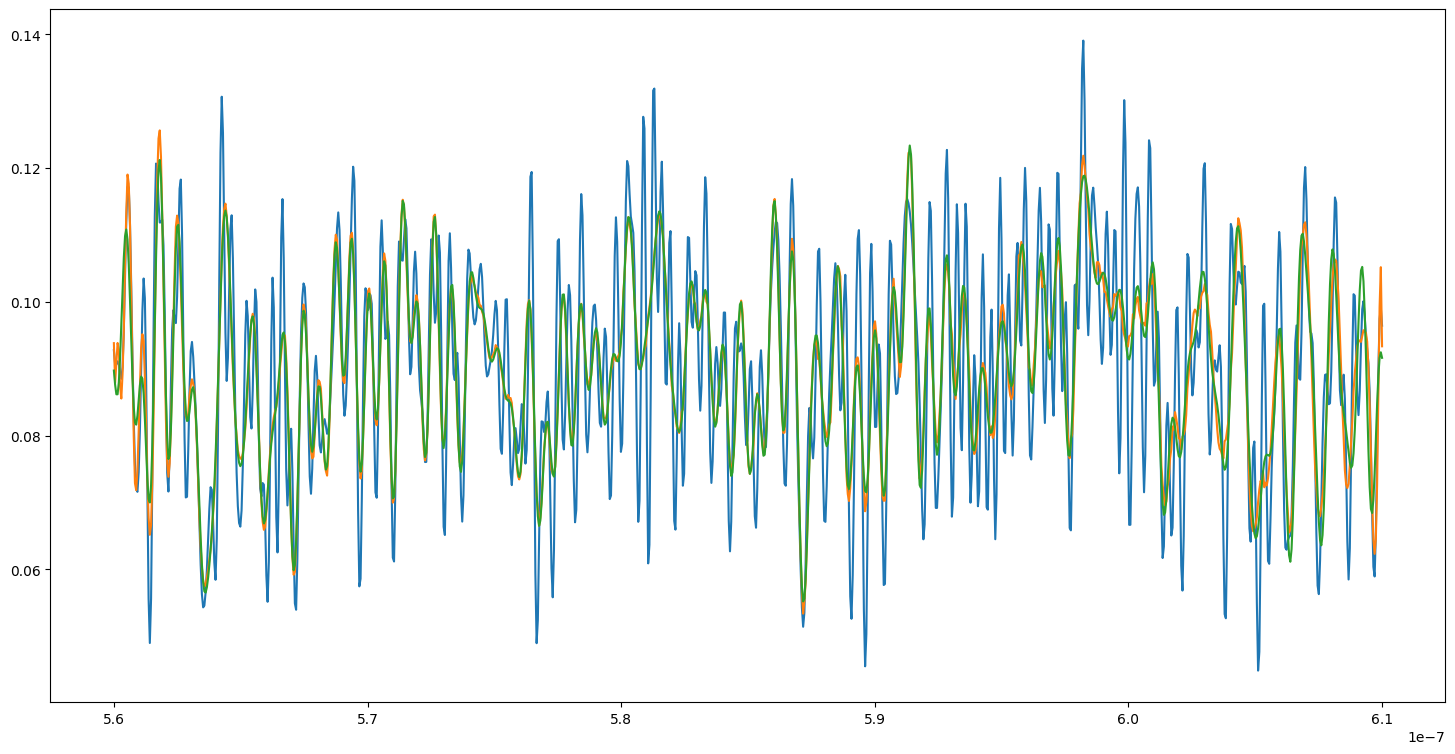

In [123]:
plt.figure(figsize=(18,9))
plt.plot(wavelengths, signal)
plt.plot(wavelengths, signal_rec)
plt.plot(wavelengths, signal_filtered_bad)
plt.show()

/Users/milolangker/anaconda3/envs/localToliman/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/milolangker/anaconda3/envs/localToliman/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


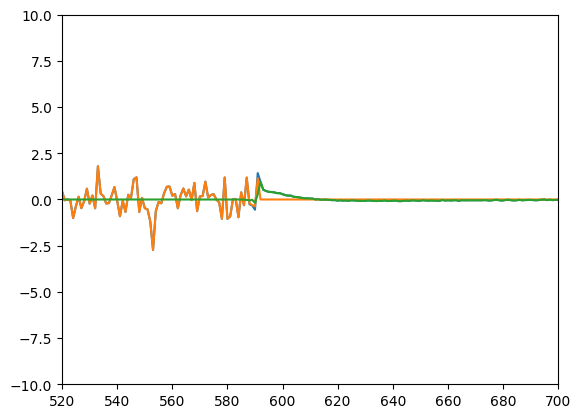

In [175]:
plt.plot(np.fft.fftshift(np.fft.fft(signal_rec)))
plt.plot(np.fft.fftshift(np.fft.fft(signal_filtered_bad)))
plt.plot(np.fft.fftshift(np.fft.fft(signal_rec)) - np.fft.fftshift(np.fft.fft(signal_filtered_bad)))
plt.xlim(520,700)
plt.ylim(-10,10)
plt.show()

In [124]:
flux = 40*(2.909*10**7)*(4/11)

difference = np.pi * 0.348
flux_renorm = flux #/(jv(0, difference/4)**2 * jv(1, difference/4)**2)

source = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal)

source_filtered = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal_rec)

source_filtered_bad = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal_filtered_bad)

wf_npixels = 128 # 128 lowest power of 2 necessary

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 128
assumed_pixel_scale = 0.375

psf_pixel_scale = assumed_pixel_scale

oversample = 2 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,psf_pixel_scale,oversample)
center_wl = 585e-9

telescope = dl.Telescope(optics, source)
telescope_filtered = dl.Telescope(optics, source_filtered)
telescope_filtered_bad = dl.Telescope(optics, source_filtered_bad)

sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)
sidelobescope_filtered = dlT.SideLobeTelescope(telescope_filtered, period, difference)
sidelobescope_filtered_bad = dlT.SideLobeTelescope(telescope_filtered_bad, period, difference)

# model sure to include our assumed pixel scale
sidelobe_raw = sidelobescope.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample = oversample)
sidelobe_filtered_raw = sidelobescope_filtered.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample=oversample)
sidelobe_filtered_bad_raw = sidelobescope_filtered_bad.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample=oversample)

sidelobe_poisson = jr.poisson(key, sidelobe_raw)

Model time: 18.6146 seconds.
Model time: 18.8536 seconds.
Model time: 16.6502 seconds.


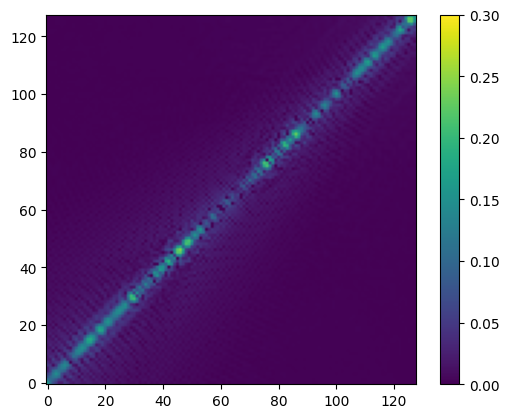

In [127]:
plt.imshow(np.abs(sidelobe_filtered_raw - sidelobe_raw)**0.5, origin='lower', vmin=0, vmax=0.3)
plt.colorbar()
plt.show()

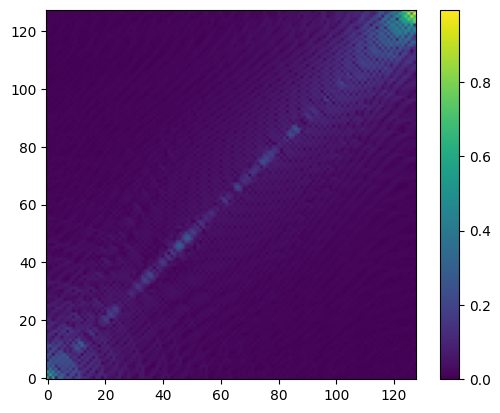

In [163]:
plt.imshow(np.abs(sidelobe_filtered_bad_raw-sidelobe_raw)**0.5, origin='lower' ,vmin=0,) #vmax = 0.3)
plt.colorbar()
plt.show()

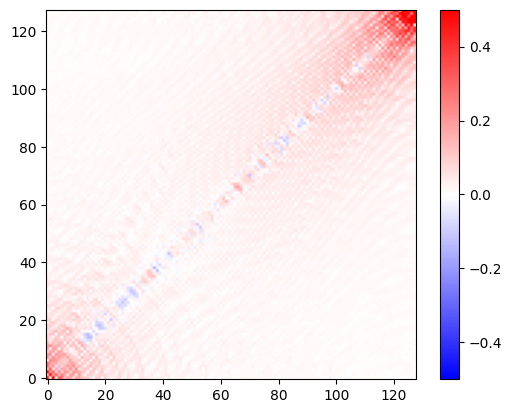

In [ ]:
plt.imshow(np.abs(sidelobe_filtered_bad_raw-sidelobe_raw)**0.5-np.abs(sidelobe_filtered_raw - sidelobe_raw)**0.5, origin='lower', cmap='bwr', vmin=-0.5,vmax=0.5)
plt.colorbar()
plt.show()
# wanna say the SVD method is better?

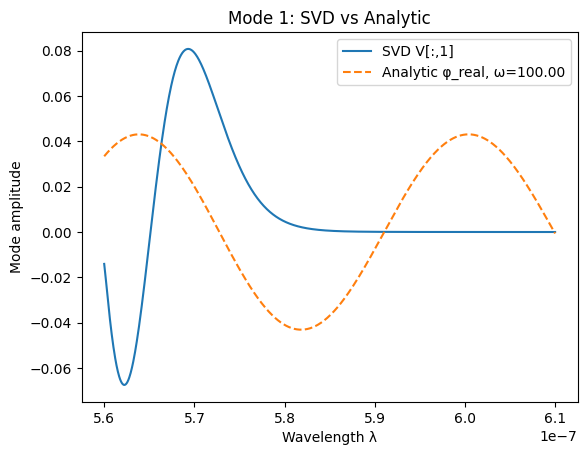

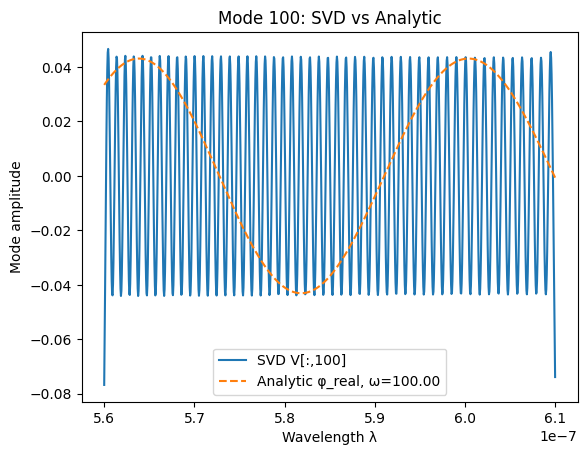

In [184]:
import numpy as np
import matplotlib.pyplot as plt

# Assume lam (wavelength vector), V (singular vectors), and S (singular values) 
# have been computed as in the previous SVD step.

# 1) Build log-wavelength grid
u = np.log(wavelengths)
du = u[1] - u[0]

# 2) Define angular frequencies (rad per unit u)
# these freqs won't work.. not linear spacing.
freqs = np.fft.fftfreq(len(u), d=du)
omega = 2 * np.pi * freqs

# 3) Select a couple of non-DC modes to compare (first modes after k=0)
modes = [1, 100]

# this is totally cheating and not what I asked it to do btw..
for k in modes:
    vk = V[:, k]               # discrete SVD singular vector at index k
    
    # 4) Remove the 1/√λ envelope to isolate the oscillatory part
    h = vk / (wavelengths**1)
    
    # 5) FFT in log-domain to find dominant ω_k
    H = np.fft.fft(h)
    peak_idx = np.argmax(np.abs(H))
    omega_k = omega[peak_idx]
    omega_k=100
    # 6) Reconstruct the analytic eigenfunction φ_k(λ) = λ^{1/2} e^{i ω_k u}
    phi = wavelengths**0 * np.exp(1j * omega_k * u)
    
    # 7) Scale the real part of φ to match vk amplitude
    phi_real = phi.real * (np.linalg.norm(vk) / np.linalg.norm(phi.real))

    # 8) Plot comparison
    plt.figure()
    plt.plot(wavelengths, vk, label=f'SVD V[:,{k}]')
    plt.plot(wavelengths, phi_real, '--', label=f'Analytic φ_real, ω={omega_k:.2f}')
    #plt.plot(wavelengths, wavelengths**0* (np.linalg.norm(vk) / np.linalg.norm(wavelengths**0.5)))
    plt.xlabel('Wavelength λ')
    plt.ylabel('Mode amplitude')
    plt.title(f'Mode {k}: SVD vs Analytic')
    plt.legend()

plt.show()


In [155]:
freq = 1000
stuff = wavelengths**(1j * freq + 1)

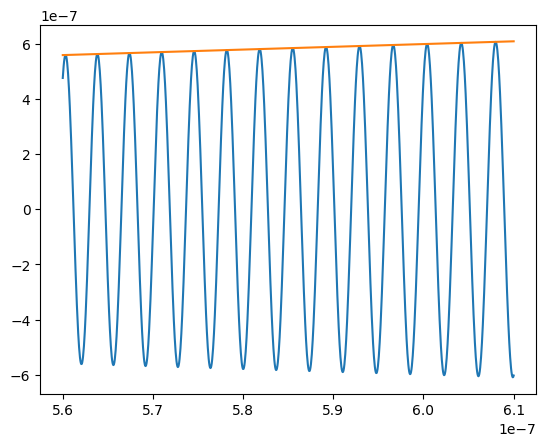

In [156]:
plt.plot(wavelengths, stuff.real)
plt.plot(wavelengths, wavelengths)
plt.show()